## Changelog:

* v8 Checking code and revising the debug files. Ready for debugging 
* V9 Adding resampling
* V10 Adding tensorboard
* V11 Reducing LSTM layer to 1 in order to have better interpretation in tensorboard
* V12 adding actionId to data in order to debug datasets and step better + fixing the wrong column name for x_prepared + **fixing LABEL WRONG!!!!! ASSIENMENT **
* V13 removing masking layer and padding with 0 or 9999
* V14 removing two outputs
* V15 returning the masking layer with mask value 99.
    - The result is that without adding masking layer the training accuracy does not increase at all and it remains the same on nearly 50
    - however the validation accuracy remains the same around 50 and does not increase while the validation loss is being increased as allways
* V16 Changing the optimizer to SGD
* V17 Changing the optimizer to rmsprop
* V18 Increasing batch size from 1 to higher and coming back the optimizer to Adam (both roc and accuracy on train was about .9 while the accuracy of validation was 0.5
* V19 Separating validation set from data and feed to the fit function using validation_data param
* V20 Adding another layer of 100 unit

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from Vis import plot_loss, plot_roc
from Preprocessing import Preprocessing
from Preprocessing import Cols
import numpy as np
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from pandas import DataFrame
from pandas import Series
import pandas as pd
from keras.layers import Dropout
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from keras import optimizers
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# pandas.set_option('max_columns',10)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
pre = Preprocessing()
X, y = pre.load_data(time_gap=300)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


In [3]:
per_action_dataset = pre.per_action_dataset
per_action_dataset.index = per_action_dataset.ITEST_id
per_action_dataset = per_action_dataset.drop(['ITEST_id', 'assistmentId', 'problemId', 'assignmentId', 'actionId'], axis=1)

In [4]:
# defining sequence length (or number of time-steps) for each student and batch-size
max_length_seq = 1000

In [5]:
# show the seq of a sample student (id =9)
#per_action_dataset[per_action_dataset.index.get_level_values(0) ==9].head()
# per_action_dataset.to_csv("Debug/1-per_action_dataset.csv")

In [6]:
#truncating seq of each student and only considering his last 500 actions based on startTime feature
truncated_input = per_action_dataset.sort_values("startTime",ascending=False).groupby('ITEST_id').head(max_length_seq)
# truncated_input.to_csv("Debug/2-truncated_input.csv")

In [7]:
# scaling dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(truncated_input)
X_scaled = DataFrame(X_scaled, index=truncated_input.index, columns=truncated_input.columns)
#X_scaled[X_scaled.index.get_level_values(0) ==9].head()
# X_scaled.to_csv("Debug/3-X_scaled.csv")

In [8]:
# fig, ax = plt.subplots()  # create figure & 1 axis
# X_scaled.boxplot(X_scaled.columns.difference(["startTime", 'endTime']).values.tolist(),ax=ax)
# fig.set_size_inches(100,100)
# fig.savefig('X_scaled.png')   # save the figure to file
# plt.close(fig) 

In [9]:
batch_size=10

In [10]:
# padding sequences to have a same length
X_padded = []
for stud_id, stud_seq in X_scaled.groupby('ITEST_id'):
    X_padded.append(stud_seq)
X_padded = sequence.pad_sequences(X_padded, max_length_seq, dtype='float64', padding="post", truncating="post", value=99.)

In [11]:
# getting a sense about padded dataset
ITEST_ix = pd.Index(np.repeat(sorted(X_scaled.index.get_level_values(0).unique()), max_length_seq), name='ITEST_id')
new_seq_ix = pd.Index(list(range(0,max_length_seq))* X_padded.shape[0], name="seq_ix")
paddedData = DataFrame(X_padded.reshape(X_padded.shape[0]*X_padded.shape[1], -1), index=[ITEST_ix, new_seq_ix], columns=X_scaled.columns)
# paddedData.to_csv("Debug/4-paddedData.csv")

In [12]:
# creating label dataset with index as ITEST_id values
label_dataset = pre.label_dataset[['ITEST_id', 'isSTEM']]
label_dataset.index = label_dataset.ITEST_id
label_dataset = label_dataset.drop("ITEST_id", axis = 1)
#label_dataset

In [13]:
# join label with dataset to make sure we have a consistent dataset
# (of course before the training the label column will be droped from data)
X_with_label = paddedData.join(label_dataset)
#print(X_with_label.shape)
# X_with_label.to_csv("Debug/5-X_with_label.csv")

In [14]:
from sklearn.utils import resample

df_majority = X_with_label[X_with_label['isSTEM'] == 0]
df_minority = X_with_label[X_with_label['isSTEM'] == 1]

minority_len = len(df_minority.index.get_level_values(0).unique())
majority_len = len(df_majority.index.get_level_values(0).unique())

sampled_df_majority = df_majority.loc[resample(df_majority.index.get_level_values(0).unique(), n_samples=minority_len, replace=False).values]

balanced_X = pd.concat([df_minority, sampled_df_majority])

In [15]:
# y_prepared = X_with_label.groupby("ITEST_id").isSTEM.first().values
# X_prepared = X_with_label.drop("isSTEM", axis=1)
# X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[1]))
# DataFrame(X_prepared.reshape(X_prepared.shape[0] * X_prepared.shape[1], X_prepared.shape[2]), index=X_with_label.index, columns=X_with_label.columns.difference(["isSTEM"])).to_csv("Debug/6-X_prepared.csv")

#for balanced dataset only 
y_prepared = balanced_X[~balanced_X.index.get_level_values(0).duplicated()]['isSTEM'].values

X_prepared = balanced_X.drop("isSTEM", axis=1)
X_prepared_columns = X_prepared.columns
X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[1]))

# DataFrame(X_prepared.reshape(X_prepared.shape[0] * X_prepared.shape[1], X_prepared.shape[2]), index=balanced_X.index, columns=X_prepared_columns).to_csv("Debug/6-X_prepared.csv")

## Model

In [16]:
from keras.layers import Masking

def create_LSTM_model(max_length_seq, feature_size):
    model = Sequential()
    model.add(Masking(mask_value=99., input_shape=(max_length_seq, feature_size)))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
#   sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

In [17]:
# splitting train/test data 
X_train, X_test, y_train,y_test = train_test_split(X_prepared,y_prepared, train_size=.77)
# enc = OneHotEncoder()
# y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
# y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()

In [18]:
from keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=batch_size, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [19]:
# Create model
model = create_LSTM_model(max_length_seq, X_train.shape[2])
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data= (X_test,y_test), callbacks=[tensorboard_callback])

Train on 180 samples, validate on 54 samples
Epoch 1/10
180/180 [==============================] - 41s 230ms/step - loss: 0.7181 - acc: 0.4167 - val_loss: 0.6856 - val_acc: 0.5370
Epoch 2/10
180/180 [==============================] - 37s 205ms/step - loss: 0.6668 - acc: 0.6056 - val_loss: 0.7056 - val_acc: 0.4630
Epoch 3/10
180/180 [==============================] - 37s 206ms/step - loss: 0.6438 - acc: 0.6167 - val_loss: 0.7262 - val_acc: 0.5556
Epoch 4/10
180/180 [==============================] - 37s 206ms/step - loss: 0.6055 - acc: 0.6833 - val_loss: 0.8093 - val_acc: 0.4630
Epoch 5/10
180/180 [==============================] - 37s 206ms/step - loss: 0.5088 - acc: 0.7556 - val_loss: 0.7693 - val_acc: 0.5185
Epoch 6/10
180/180 [==============================] - 37s 206ms/step - loss: 0.4210 - acc: 0.8222 - val_loss: 0.8284 - val_acc: 0.5185
Epoch 7/10
180/180 [==============================] - 37s 206ms/step - loss: 0.3137 - acc: 0.9111 - val_loss: 0.9094 - val_acc: 0.5741
Epoch 8/10

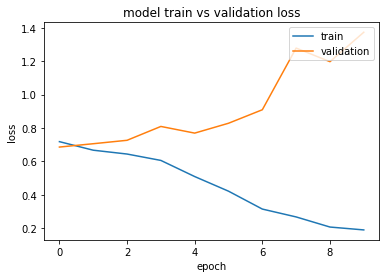

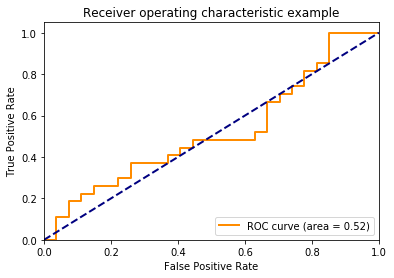

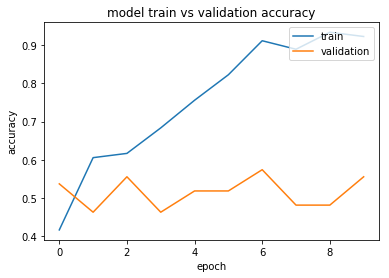

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 1000, 47)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 100)         59200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 139,701
Trainable params: 139,701
Non-trainable params: 0
_________________________________________________________________
None
Test ROC Score: 0.518519
Test RMSE Score: 0.623825
Final Competition Score: 0.894693


In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from Vis import plot_accuracy
# do prediction
y_pred = model.predict(X_test, batch_size=batch_size)

# calculating scores
roc_score = roc_auc_score(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)

#printing and plotting model and score information
plot_loss(history)
plot_roc(y_test, y_pred)
# plot_roc(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
plot_accuracy(history)

print(model.summary())
print("Test ROC Score: %f" % roc_score)
print("Test RMSE Score: %f" % sqrt(mse_score))
print("Final Competition Score: %f" % (1 - sqrt(mse_score) + roc_score))